In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tsfresh.feature_extraction import feature_calculators
# %matplotlib widget
%run src/dataloader.py
%run options.py

args = Options().parsenb()
args.dataname = "SMAP"
if args.dataname == "SMD":
    args.xdim = 38
    oneside_len = 100
elif args.dataname == "MSL":
    args.xdim = 55
    oneside_len = 50
elif args.dataname == "PSM":
    args.xdim = 25
elif args.dataname == "SMAP":
    args.xdim = 25

TSLOADER = TSDataLoader(args.dataname, args.win_size, args.win_step, "train")
train_x, train_y, valid_x, valid_y, test_x, test_y = TSLOADER._getdata(args.dataname)
# print(" @Real Test Shape:", test_y.shape)

# Load Results
anomalyscore = np.load("save/results/anomalyscore-{}.npy".format(args.dataname))
anomalyscore_rec = np.load("save/results/anomalyscore-rec-{}.npy".format(args.dataname))
anomalyscore_sim = np.load("save/results/anomalyscore-sim-{}.npy".format(args.dataname))
gt = np.load("save/results/gt-{}.npy".format(args.dataname))
pred = np.load("save/results/pred-{}.npy".format(args.dataname))
recdata = np.load("save/results/recdata-{}.npy".format(args.dataname))
# print(" @Actual Test Shape:", pred.shape)

# FP / FN / TPTN
e =  np.array(list(map(lambda x, y: x - y, gt, pred)), dtype=int)
idx_fn = list(np.where(e == 1)[0])
idx_fp = list(np.where(e == -1)[0])
idx_tptn = list(np.where(e == 0)[0])

# split fp/fn
def splitwindows(x, mode="fp"):
    aps = {}
    x.append(0)
    win = []
    p = 0
    for k in range(len(x)-1):
        if x[k+1]-x[k] == 1:
            win.append(x[k])
        elif x[k+1]-x[k] > 1:
            win.append(x[k])
            aps["{}-win-{}".format(mode, p)] = win
            p = p + 1
            win = []
        elif x[k+1]-x[k] < 1:
            win.append(x[k])
            aps["{}-win-{}".format(mode, p)] = win
    return aps
windows_fp = splitwindows(idx_fp, "fp")
windows_fn = splitwindows(idx_fn, "fn")
windows_tptn = splitwindows(idx_tptn, "tptn")
print("Number of FP/FN/TPTN Windows", len(windows_fp), len(windows_fn), len(windows_tptn))

Number of FP/FN/TPTN Windows 5061 3 5064


## Plot Results

start/end: 5400 5801


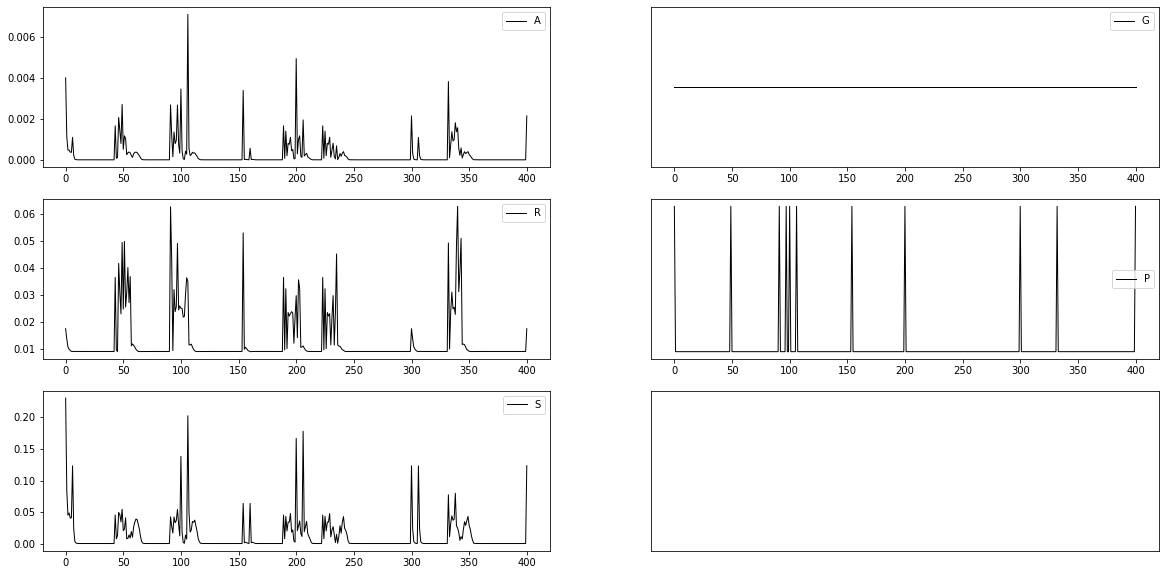

In [332]:
# Plot anomaly score 
case = "fp"
window_idx = "100"
single_range = 200
if case == "fp":
    assert int(window_idx) < len(windows_fp)
    s = windows_fp["{}-win-{}".format("fp", window_idx)][0] - single_range
    e = windows_fp["{}-win-{}".format("fp", window_idx)][-1] + 1 + single_range
    if s < 0:
        s = 0 
    elif s > len(gt)-1:
        s = len(gt)-1
    print("start/end:", s,e)
elif case == "fn":
    assert int(window_idx) < len(windows_fn)
    s = windows_fn["{}-win-{}".format("fn", window_idx)][0] - single_range
    e = windows_fn["{}-win-{}".format("fn", window_idx)][-1] + 1 + single_range
    if s < 0:
        s = 0 
    elif s > len(gt)-1:
        s = len(gt)-1
    print("start/end:", s,e)

plotx = test_x[s:e, :]
ploty = test_y[s:e]
plotanomalyscore = anomalyscore[s:e]
plotrec = anomalyscore_rec[s:e]
plotsim = anomalyscore_sim[s:e]
plotgt = gt[s:e]
plotpred = pred[s:e]
plotrecdata = recdata[s:e, :]

fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0][0].plot(plotanomalyscore, color="black", linewidth=1)
axes[0][0].legend("Anomaly Score")
# axes[0][0].set_xticks([])
# axes[0][0].set_yticks([])
axes[1][0].plot(plotrec, color="black", linewidth=1)
axes[1][0].legend("Rec Score")
# axes[1][0].set_xticks([])
# axes[1][0].set_yticks([])
axes[2][0].plot(plotsim, color="black", linewidth=1)
axes[2][0].legend("Sim Score")
# axes[2][0].set_xticks([])
# axes[2][0].set_yticks([])

axes[0][1].plot(plotgt, color="black", linewidth=1)
axes[0][1].legend("Ground Truth Label")
# axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[1][1].plot(plotpred, color="black", linewidth=1)
axes[1][1].legend("Predicted Label")
# axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

axes[2][1].set_xticks([])
axes[2][1].set_yticks([])
plt.show()
# print("\n----------------------------------------------------------")
# print("Plot Max Kur Dim")
# # Plot max-5 kur in each dim
# D = plotx.shape[-1]
# kur = np.zeros(D)
# for d in range(D):
#     x_ = plotx[:, d]
#     kur[d] = feature_calculators.kurtosis(x_)
# maxkur_idx = np.argsort(kur)[::-1]
# n_max = 5
# maxkur_idx = maxkur_idx[0:n_max]
# print("Kurtosis_idx", maxkur_idx)
# makkur = kur[maxkur_idx]
# print("Kurtosis", makkur)
# # print("Kurtosis", kur)
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))
# for k in range(len(maxkur_idx)):
#     axes[k].plot(plotx[:, maxkur_idx[k]], color='black', linewidth=1)
#     axes[k].set_title("Dim={}".format(maxkur_idx[k]))
#     axes[k].set_yticks([])
# plt.show()

# print("\n----------------------------------------------------------")
# print("Plot Raw Data")
# nc = 5
# nr = int(args.x_dim/nc) + 1
# fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(20, 25))
# d=0
# for i in range(nr):
#     for k in range(nc):
#         if d < args.xdim:
#             data_ = plotx[:, d]
#             axes[i, k].plot(data_, color='black', linewidth=1)
#             axes[i, k].set_title("Dim={}".format(d))
#             axes[i, k].set_yticks([])
#         d = d + 1
# plt.show()


# print("\n----------------------------------------------------------")
# print("Plot Rec Data")
# nc = 5
# nr = int(args.x_dim/nc) + 1
# fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(20, 25))
# d=0
# for i in range(nr):
#     for k in range(nc):
#         if d < args.xdim:
#             data_ = plotrec[:, d]
#             axes[i, k].plot(data_, color='black', linewidth=1)
#             axes[i, k].set_title("Dim={}".format(d))
#             axes[i, k].set_yticks([])
#         d = d + 1
# plt.show()

## Plot Rec/Raw data

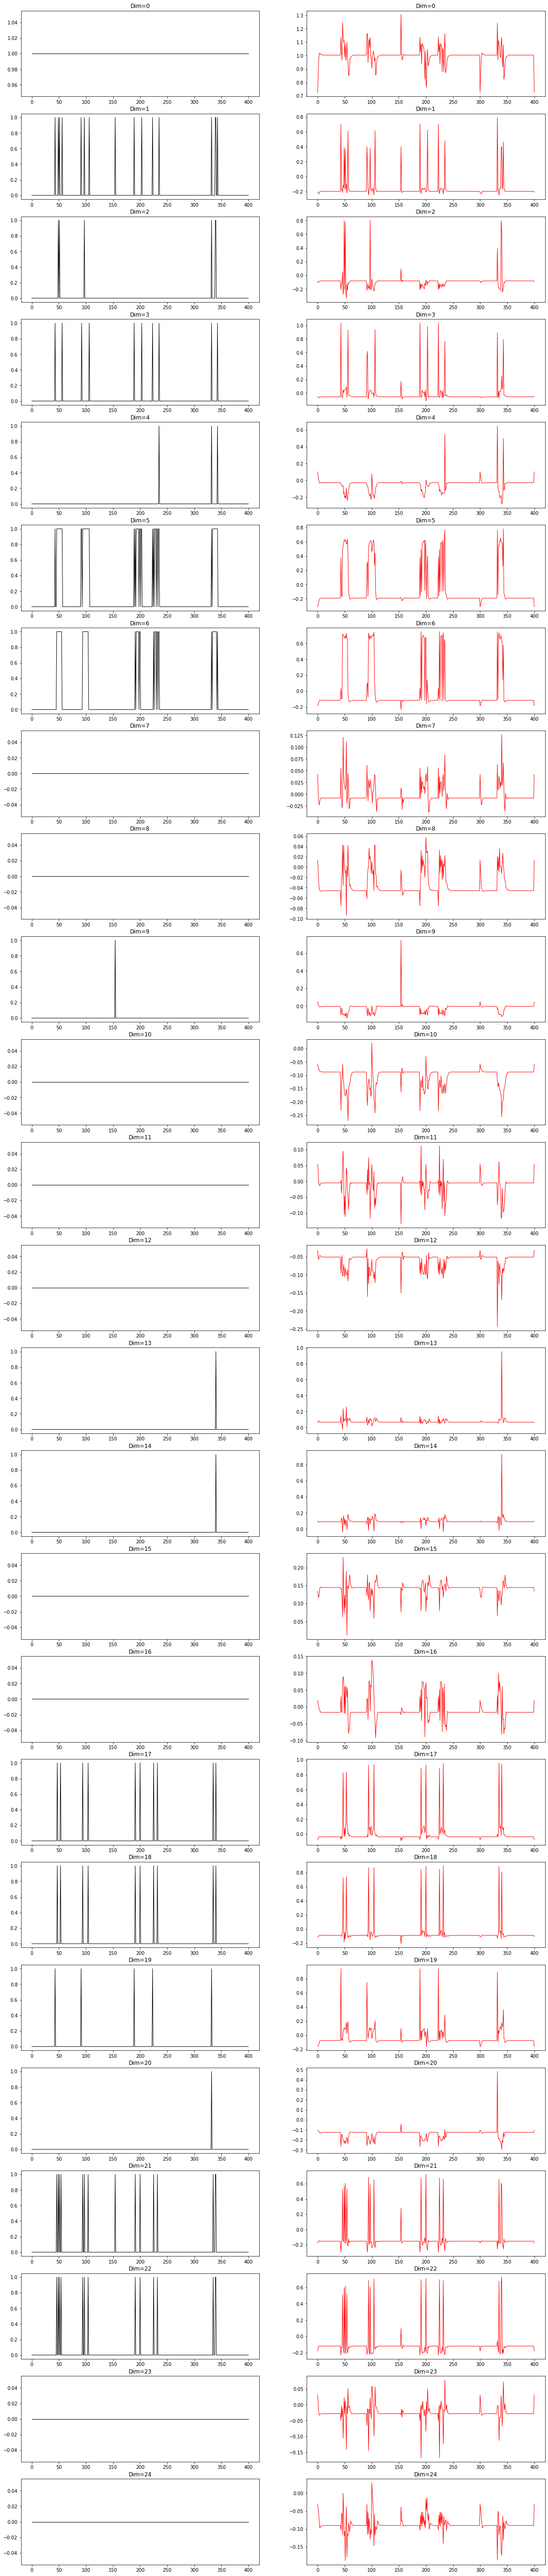

In [333]:
# print("\n----------------------------------------------------------")
# print("Plot Raw Data / Rec")

fig, axes = plt.subplots(nrows=plotx.shape[-1], ncols=2, figsize=(20, 100))
d=0
for i in range(plotx.shape[-1]):
    axes[i][0].plot(plotx[:, i], color='black', linewidth=1)
    axes[i][0].set_title("Dim={}".format(i))
    axes[i][1].plot(plotrecdata[:, i], color='red', linewidth=1)
    axes[i][1].set_title("Dim={}".format(i))
plt.show()

In [315]:
x = torch.rand(2, 5, 3)
x

tensor([[[0.3861, 0.7590, 0.2302],
         [0.1776, 0.7388, 0.7176],
         [0.8418, 0.0681, 0.8914],
         [0.1541, 0.5236, 0.0714],
         [0.0364, 0.7577, 0.5001]],

        [[0.7282, 0.7182, 0.8526],
         [0.8476, 0.8224, 0.9284],
         [0.3604, 0.5225, 0.5306],
         [0.6791, 0.3274, 0.9445],
         [0.8020, 0.3731, 0.3725]]])

In [355]:
p = torch.rand(20, 3)
p

tensor([[0.2374, 0.1739, 0.8241],
        [0.0114, 0.2371, 0.5544],
        [0.8881, 0.2915, 0.5884],
        [0.7933, 0.8331, 0.8566],
        [0.2782, 0.7476, 0.3636],
        [0.5001, 0.7178, 0.5379],
        [0.8098, 0.2259, 0.4113],
        [0.7623, 0.8173, 0.0199],
        [0.2236, 0.6968, 0.0361],
        [0.9856, 0.0973, 0.6395],
        [0.4596, 0.9614, 0.5907],
        [0.6876, 0.7308, 0.5424],
        [0.5673, 0.9190, 0.4413],
        [0.1547, 0.7347, 0.9529],
        [0.2108, 0.0367, 0.7287],
        [0.7546, 0.1006, 0.1053],
        [0.7628, 0.2156, 0.8557],
        [0.5485, 0.8741, 0.5546],
        [0.8724, 0.4634, 0.2156],
        [0.7512, 0.7498, 0.8124]])

In [356]:
step = 3
hist = torch.flip(torch.flip(p, dims=[0])[step::step], dims=[0])
hist

tensor([[0.0114, 0.2371, 0.5544],
        [0.2782, 0.7476, 0.3636],
        [0.7623, 0.8173, 0.0199],
        [0.4596, 0.9614, 0.5907],
        [0.1547, 0.7347, 0.9529],
        [0.7628, 0.2156, 0.8557]])

In [318]:
v = torch.cat((c,p), dim=1)
v

tensor([[[0.1541, 0.5236, 0.0714],
         [0.0364, 0.7577, 0.5001],
         [0.3861, 0.7590, 0.2302],
         [0.1776, 0.7388, 0.7176],
         [0.8418, 0.0681, 0.8914]],

        [[0.6791, 0.3274, 0.9445],
         [0.8020, 0.3731, 0.3725],
         [0.7282, 0.7182, 0.8526],
         [0.8476, 0.8224, 0.9284],
         [0.3604, 0.5225, 0.5306]]])

###### Plot Recdata

In [167]:
def calculate_kur(x):
    B, L, D = x.shape
    meanv = torch.mean(x, dim=1).unsqueeze(dim=1)
    meanv = repeat(meanv, "B L D -> B (repeat L) D", repeat=L)
    std = torch.std(x, dim=1)
    corr_one = torch.ones_like(std)
    corr_zero = torch.zeros_like(std)
    corr = torch.where(std>0, corr_one, corr_zero)
    m4 = torch.mean((x - meanv) ** 4, dim=1)
    m2 = torch.mean((x - meanv) ** 2, dim=1) + 0.0001
    kur = m4 / (m2 ** 2) * corr
    
    return kur


pp = torch.tensor(plotx[:, 33:35]).unsqueeze(0)
out = calculate_kur(pp)
out

tensor([[0., 0.]], dtype=torch.float64)

In [158]:

out

tensor([[5.9347e-59, 0.0000e+00]], dtype=torch.float64)

In [162]:
p = plotx[:, 9]

mv = np.mean(p)
m4 = np.mean((p-mv)**4)
m2 = np.mean((p-mv)**2)+0.0001

out = m4 / (m2**2)
out

0.0

In [152]:
p

array([-0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01242388,
       -0.01242388, -0.01242388, -0.01242388, -0.01242388, -0.01

## Frequency

In [121]:
tf = torch.tensor(plotx)
tf.shape

torch.Size([201, 55])

In [122]:
tf_freq = torch.fft.fft(tf, dim=0)
tf_freq.shape

torch.Size([201, 55])

/home/kexin/anaconda3/envs/torch102/lib/python3.6/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


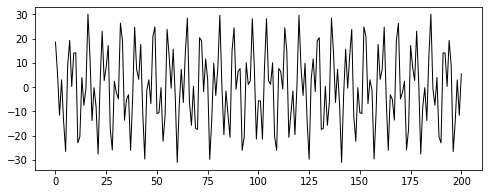

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
axes.plot(tf_freq[:,19], color='black', linewidth=1)

In [124]:
tf_freq[19]

tensor([ 4.4511e-02+2.0140e+00j,  0.0000e+00+0.0000e+00j,
        -9.8305e-18+6.6382e-18j, -1.8929e-17+1.2782e-17j,
         0.0000e+00+0.0000e+00j, -1.2437e+01+8.8550e+00j,
        -5.8199e-17+3.9300e-17j,  2.0582e+01+3.9854e+01j,
         0.0000e+00+0.0000e+00j, -2.7521e-17+1.8584e-17j,
         0.0000e+00+0.0000e+00j, -4.8142e+00+6.7376e+00j,
        -3.3366e+00-1.1855e+01j, -3.3139e-16+2.2378e-16j,
        -3.3851e-16+2.2858e-16j, -1.2021e-17+8.1173e-18j,
        -1.5770e-17+1.0649e-17j, -1.0209e-17+6.8937e-18j,
         0.0000e+00+0.0000e+00j, -1.8737e-01+2.3976e+01j,
        -4.4541e-17+3.0077e-17j,  0.0000e+00+0.0000e+00j,
         0.0000e+00+0.0000e+00j, -1.1510e-17+7.7725e-18j,
         0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
         0.0000e+00+0.0000e+00j, -8.5966e+00+7.9413e+00j,
        -1.2497e-17+8.4390e-18j,  2.3701e+00+1.4022e+02j,
         0.0000e+00+0.0000e+00j, -3.9475e-17+2.6656e-17j,
         0.0000e+00+0.0000e+00j, -3.3397e-16+2.2552e-16j,
         0.000

In [144]:
x = torch.rand(3, 5)
x

tensor([[0.0576, 0.1204, 0.7609, 0.8330, 0.0671],
        [0.6861, 0.2713, 0.1177, 0.5927, 0.2411],
        [0.4344, 0.8240, 0.7729, 0.9884, 0.8595]])

In [145]:
x = x.unsqueeze(dim=1)
x

tensor([[[0.0576, 0.1204, 0.7609, 0.8330, 0.0671]],

        [[0.6861, 0.2713, 0.1177, 0.5927, 0.2411]],

        [[0.4344, 0.8240, 0.7729, 0.9884, 0.8595]]])

In [147]:
from einops import repeat
x = repeat(x, "B L D -> B (repeat L) D", repeat=3)
x

tensor([[[0.0576, 0.1204, 0.7609, 0.8330, 0.0671],
         [0.0576, 0.1204, 0.7609, 0.8330, 0.0671],
         [0.0576, 0.1204, 0.7609, 0.8330, 0.0671]],

        [[0.6861, 0.2713, 0.1177, 0.5927, 0.2411],
         [0.6861, 0.2713, 0.1177, 0.5927, 0.2411],
         [0.6861, 0.2713, 0.1177, 0.5927, 0.2411]],

        [[0.4344, 0.8240, 0.7729, 0.9884, 0.8595],
         [0.4344, 0.8240, 0.7729, 0.9884, 0.8595],
         [0.4344, 0.8240, 0.7729, 0.9884, 0.8595]]])